In [30]:
import numpy as np
import pandas as pd

# Evaluate CI On Trained Survival Model

In [7]:
data = pd.read_csv("./data/genentech_processed.tsv", sep="\t")
survival = pd.read_csv("./data/genentech_processed.surv.tsv", sep="\t")
response = pd.read_csv("./data/genentech_processed.labels.tsv", sep="\t").values.flatten()

In [8]:
from keras.models import load_model
from keras import backend as K
import tensorflow as tf

def negative_log_partial_likelihood(censor, risk):
    """Return the negative log-partial likelihood of the prediction
    y_true contains the survival time
    risk is the risk output from the neural network
    censor is the vector of inputs that are censored
    regularization is the regularization constant (not used currently in model)

    Uses the Keras backend to perform calculations

    Sorts the surv_time by sorted reverse time
    """

    # calculate negative log likelihood from estimated risk
    epsilon = 0.001
    risk = K.reshape(risk, [-1])  # flatten
    hazard_ratio = K.exp(risk)

    # cumsum on sorted surv time accounts for concordance
    log_risk = K.log(tf.cumsum(hazard_ratio)+epsilon)
    log_risk = K.reshape(log_risk, [-1])
    uncensored_likelihood = risk - log_risk

    # apply censor mask: 1 - dead, 0 - censor
    censored_likelihood = uncensored_likelihood * censor
    num_observed_events = K.sum(censor)
    neg_likelihood = - K.sum(censored_likelihood) / \
        tf.cast(num_observed_events, tf.float32)

    return neg_likelihood

Using TensorFlow backend.


In [10]:
from lifelines.utils import concordance_index

def concordance_metric(survival_time, predicted_risk, censor):
    # calculate the concordance index
    epsilon = 0.001
    partial_hazard = np.exp(-(predicted_risk+epsilon)).flatten()
    censor = censor.astype(int)
    ci = concordance_index(survival_time, partial_hazard, censor)
    return ci

OS = survival[['OS']].values.flatten()
event = survival[['Event']].values.flatten()

In [11]:
files = ["/home/pzs2/capstone/models/surv_immune_xfer_10_28__00_47/surv/checkpoint.0350.hdf5"]

for hdf5 in files:
    surv_model = load_model(hdf5, custom_objects={
                                            'negative_log_partial_likelihood': negative_log_partial_likelihood})
    predictions = surv_model.predict(data)
    ci = concordance_metric(OS, np.exp(predictions), event)
    print("File: {}, CI: {}".format(hdf5, ci))

File: /home/pzs2/capstone/models/surv_immune_xfer_10_28__00_47/surv/checkpoint.0350.hdf5, CI: 0.495643000027


/home/pzs2/keras/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


# Transfer Learning

In [12]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import random

def shuffle(X, y):
    shuffle_indices = np.random.permutation(np.arange(len(y)))
    X = X[shuffle_indices,:]
    y = y[shuffle_indices]
    return X,y

# read in datasets
data = pd.read_csv("./data/genentech_processed.tsv", sep="\t")
clinical = pd.read_csv("./data/genentech_processed.labels.tsv", sep="\t")

# parse out features and labels
labels = response
data = data.values

random.seed(1239)

data, labels = shuffle(data,labels)

sm = SMOTETomek(ratio='auto')
data, labels = sm.fit_sample(data, labels)

# split out a test set
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.15, stratify=labels)

# split out a validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, stratify=y_train)

x_train, y_train = shuffle(x_train, y_train)
x_val, y_val = shuffle(x_val, y_val)
x_test, y_test = shuffle(x_test, y_test)

# Turn labels into categorical values
y_train_cat = np.append(y_train.reshape([-1,1]), np.abs(y_train - 1).reshape([-1,1]), axis=1)
y_val_cat = np.append(y_val.reshape([-1,1]), np.abs(y_val - 1).reshape([-1,1]), axis=1)

In [13]:
import collections
print(collections.Counter(labels))
print(collections.Counter(y_train))
print(collections.Counter(y_val))
print(collections.Counter(y_test))

Counter({0: 228, 1: 228})
Counter({0: 155, 1: 154})
Counter({0: 39, 1: 39})
Counter({1: 35, 0: 34})


In [76]:
# pd_pdl1 = clinical[['CD274', 'PDCD1']].values
# pd_x_train, pd_x_val, pd_y_train, pd_y_val = train_test_split(data, pd_pdl1, test_size=0.20)

## Hyperparameters

In [14]:
batch_size = 32

In [15]:
surv_path = "/home/pzs2/capstone/models/surv_immune_xfer_10_28__20_10/surv/checkpoint.0380.hdf5"
pd_path = "/home/pzs2/capstone/models/surv_immune_xfer_10_28__20_10/immune/genes.hdf5"

In [16]:
# fit a model
def fit(model, lr, epoch):
    opt = Adam(lr=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy','ce'])
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epoch,
              validation_data=(x_val, y_val),
              verbose=0)
    
    train_eval = model.evaluate(x=x_train, y=y_train, verbose=0)
    val_eval = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    return model, train_eval, val_eval, history

## Model From Scratch

In [17]:
from keras.models import Sequential, Model, load_model
import keras.layers as layers
from keras import regularizers
from keras.optimizers import Adam

def create_rand():
    model = Sequential()
    model.add(layers.Dense(128, input_dim=x_train.shape[1],
                           kernel_regularizer=regularizers.l2(0.01),
                           activity_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

lrs_rand = [1e-3, 8e-4, 3e-4, 1e-4]
epochs_rand = [20, 20, 30, 70]
fits_rand = [fit(create_rand(),lr, epoch) for lr, epoch in zip(lrs_rand, epochs_rand) ]

## Just On Survival

In [18]:
from keras.models import Sequential, Model, load_model
import keras.layers as layers
from keras.optimizers import Adam

def create_surv():
    surv_model = Sequential()
    surv_model = load_model(surv_path, custom_objects={
                                                'negative_log_partial_likelihood': negative_log_partial_likelihood})

    # taking out the last layer layers
    surv_model.pop()
    surv_model.add(layers.Dense(1, activation="sigmoid", name="surv_output"))
    
    return surv_model


lrs_surv = [8e-4, 3e-4, 1e-4, 5e-5, 1e-5]
epochs_surv = [35, 40, 80, 150, 275]
fits_surv = [fit(create_surv(),lr, epoch) for lr, epoch in zip(lrs_surv, epochs_surv) ]

## Predicting with PD-1 / PD-L1 Layer

In [19]:
from keras.models import Sequential, Model
import keras.layers as layers
from keras.optimizers import Adam
        
# pd1_models = []
# epochs = np.array(epochs) - 10

def create_pd():
    pd1_model = Sequential()
    pd1_model = load_model(pd_path)
    
    # remove the last layer
    pd1_model.pop()
    pd1_model.add(layers.Dense(1, activation="sigmoid", name="xfer_output"))
    
    return pd1_model

lrs_pd = [8e-4, 3e-4, 8e-5, 3e-5, 8e-6]
epochs_pd = [25, 25, 80, 160, 375]
fits_pd = [fit(create_pd(),lr, epoch) for lr, epoch in zip(lrs_pd, epochs_pd) ]

## Model Evaluation

In [20]:
# returns a model with the lowest cross entropy in validation set
def get_best_model(fits, measure='ce'):
    if measure == 'ce':
        index = 2
        f = np.argmin
    elif measure == 'acc':
        index = 1
        f = np.argmax
        
    measures = [fit[2][index] for fit in fits]
    model = fits[f(measures)][0]
    
    return model

def get_history(fits):
    hist = [fit[3] for fit in fits]
    return hist

def get_ce(fits):
    ces = [[fit[1][2], fit[2][2]] for fit in fits]
    return np.array(ces).T

def get_acc(fits):
    acc = [[fit[1][1], fit[2][1]] for fit in fits]
    return np.array(acc).T

def get_acc_val(fits):
    acc = [fit[2][1] for fit in fits]
    return np.array(acc)

In [21]:
from matplotlib import pyplot as plt

accs = np.array(get_acc_val(fits_pd)).flatten()
epochs = np.array(epochs_pd).flatten()
# epochs = epochs / max(epochs)
lrs = np.array(lrs_pd).flatten()

plt.figure(figsize=(12,12))

plt.subplot(311)
plt.scatter(epochs, accs)


plt.subplot(312)
plt.scatter(accs, lrs)


plt.subplot(313)
plt.scatter(epochs, lrs)


plt.show()

<Figure size 1200x1200 with 3 Axes>

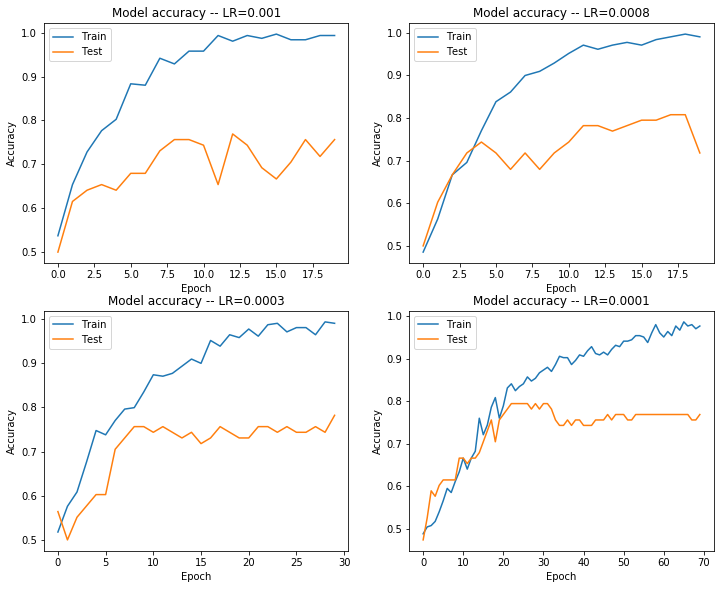

In [22]:
# Plot training & validation accuracy values

plt.figure(figsize=(12, 15))

hist = get_history(fits_rand)
lrs = lrs_rand
subplot_ind = [321, 322, 323, 324, 325, 326]


for history, lr, ind in zip(hist, lrs, subplot_ind):
    plt.subplot(ind)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy -- LR={}'.format(lr))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

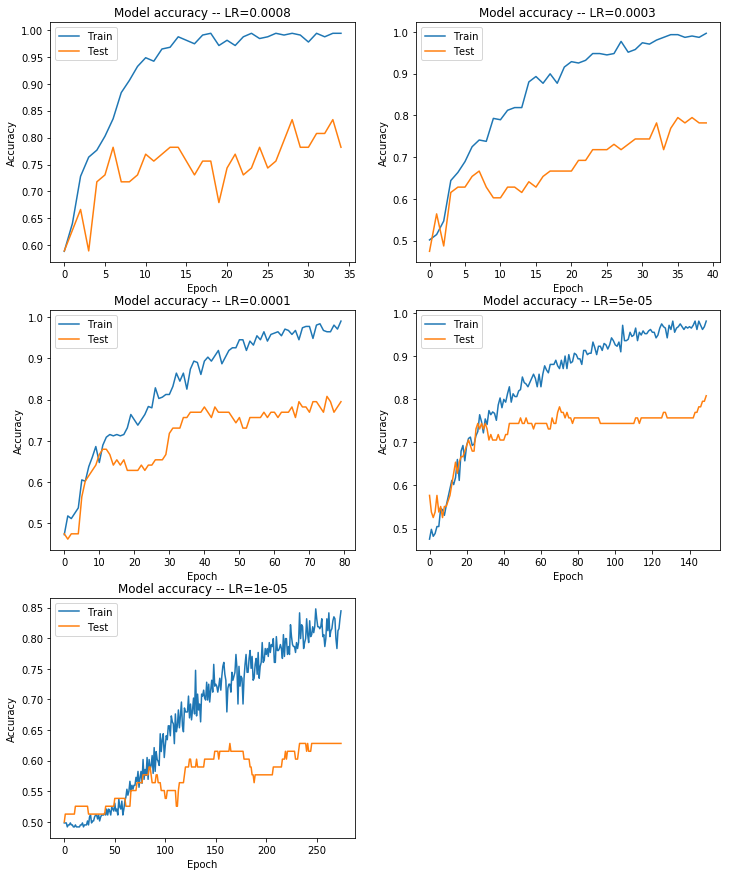

In [23]:
# Plot training & validation accuracy values

plt.figure(figsize=(12, 15))

hist = get_history(fits_surv)
lrs = lrs_surv
subplot_ind = [321, 322, 323, 324, 325, 326]


for history, lr, ind in zip(hist, lrs, subplot_ind):
    plt.subplot(ind)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy -- LR={}'.format(lr))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

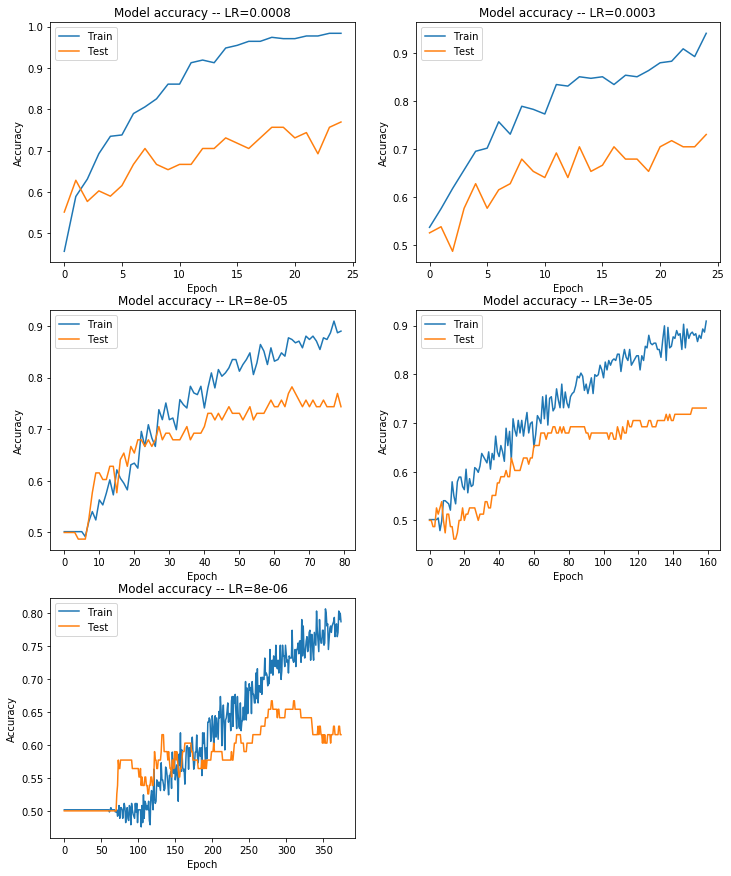

In [24]:
# Plot training & validation accuracy values

plt.figure(figsize=(12, 15))

hist = get_history(fits_pd)
lrs = lrs_pd
subplot_ind = [321, 322, 323, 324, 325, 326]


for history, lr, ind in zip(hist, lrs, subplot_ind):
    plt.subplot(ind)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy -- LR={}'.format(lr))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [25]:
# import R elastic-net results
r_en = pd.read_csv("./data/r_preds.csv")

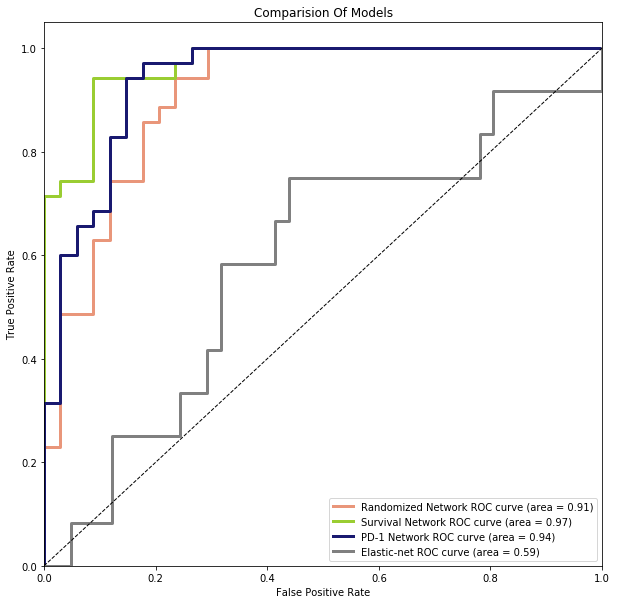

In [26]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

measure = 'acc'
test_data = x_test
test_label = y_test

# ROC for random model
model = get_best_model(fits_rand, measure)
# model = load_model("./model/random.hdf5", custom_objects={
#     'negative_log_partial_likelihood': negative_log_partial_likelihood})
predicted_events = model.predict(test_data).flatten()
fpr, tpr, threshold = roc_curve(test_label, predicted_events)
roc_auc = auc(fpr, tpr)

# ROC for survival transfer learning model
surv_model = get_best_model(fits_surv, measure)
# surv_model = load_model("./model/surv_xfer.hdf5", custom_objects={
#     'negative_log_partial_likelihood': negative_log_partial_likelihood})
predicted_events = surv_model.predict(test_data)                            
fpr_surv, tpr_surv, threshold = roc_curve(test_label, predicted_events)
roc_auc_surv = auc(fpr_surv, tpr_surv)

# ROC for PD-1 model
pd1_model = get_best_model(fits_pd, measure)
# pd1_model = load_model("./model/pd_xfer.hdf5", custom_objects={
#     'negative_log_partial_likelihood': negative_log_partial_likelihood})
predicted_events = pd1_model.predict(test_data).flatten()
fpr_xfer, tpr_xfer, threshold = roc_curve(test_label, predicted_events)
roc_auc_xfer = auc(fpr_xfer, tpr_xfer)

# elastic net ROC curve
fpr_en, tpr_en, threshold = roc_curve(r_en.iloc[:,2], r_en.iloc[:,1])
roc_auc_en = auc(fpr_en, tpr_en)

# Plot all ROC curves
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr,
         label='Randomized Network ROC curve (area = {0:0.2f})'
               ''.format(roc_auc),
         color='darksalmon', linewidth=3)

plt.plot(fpr_surv, tpr_surv,
         label='Survival Network ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_surv),
         color='yellowgreen', linewidth=3)

plt.plot(fpr_xfer, tpr_xfer,
         label='PD-1 Network ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_xfer),
         color='midnightblue', linewidth=3)

plt.plot(fpr_en, tpr_en,
         label='Elastic-net ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_en),
         color='grey', linewidth=3)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparision Of Models')
plt.legend(loc="lower right")
plt.show()

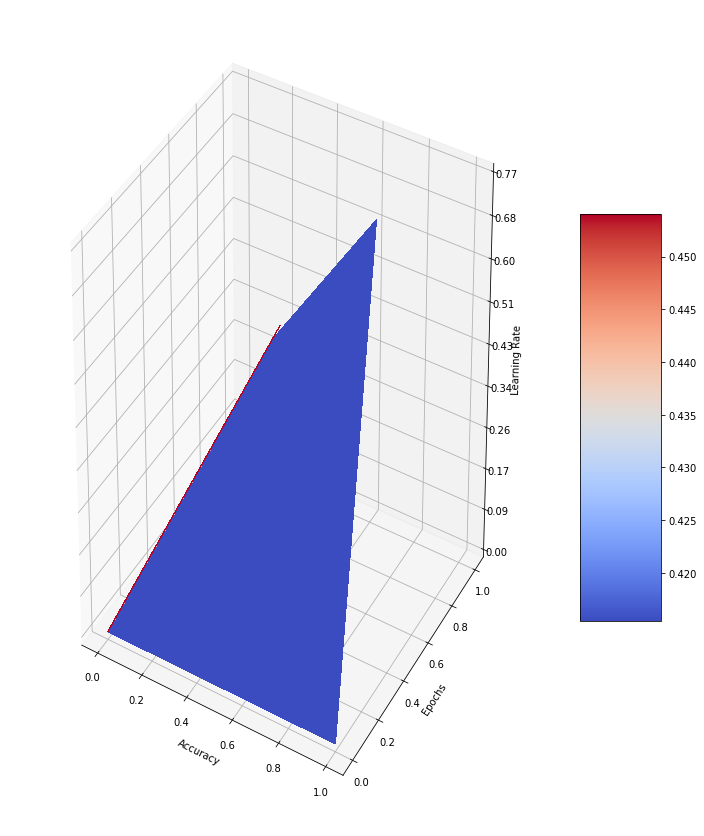

In [27]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

accs = np.array(get_acc_val(fits_pd)).flatten()
epochs = np.array(epochs_pd).flatten()
epochs = epochs / max(epochs)
lrs = np.array(lrs_pd).flatten()

accs_ep = np.array([accs, epochs])
accs_lrs = np.array([accs, lrs])
epochs_lrs = np.array([epochs, lrs])

fig = plt.figure(figsize=(12, 15))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(accs_ep, epochs_lrs , accs_lrs, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(0, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set_xlabel("Accuracy")
ax.set_ylabel("Epochs")
ax.set_zlabel("Learning Rate")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

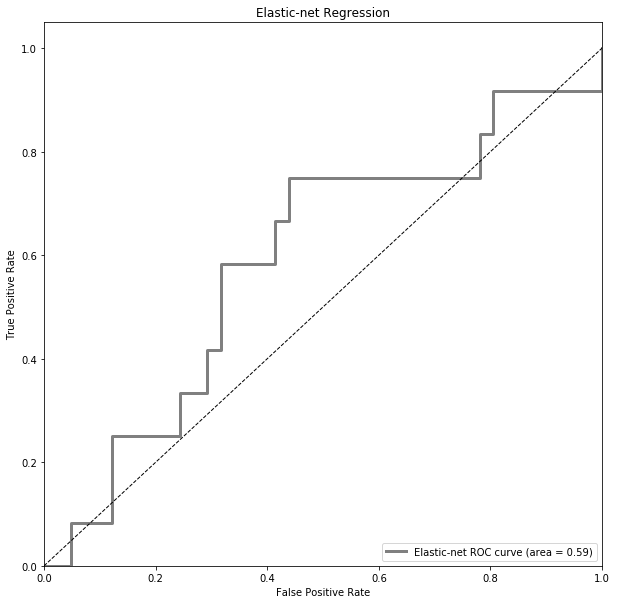

In [5]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

# import R elastic-net results
r_en = pd.read_csv("./data/r_preds.csv")

plt.figure(figsize=(10, 10))

# elastic net ROC curve
fpr_en, tpr_en, threshold = roc_curve(r_en.iloc[:,2], r_en.iloc[:,1])
roc_auc_en = auc(fpr_en, tpr_en)

plt.plot(fpr_en, tpr_en,
         label='Elastic-net ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_en),
         color='grey', linewidth=3)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Elastic-net Regression')
plt.legend(loc="lower right")
plt.show()

In [31]:
# Saving models
from keras.models import save_model
import pickle

measure = 'acc'
save_model(get_best_model(fits_rand, measure), "./model/11_11/random.hdf5")
save_model(get_best_model(fits_surv, measure), "./model/11_11/surv_xfer.hdf5")
save_model(get_best_model(fits_pd, measure), "./model/11_11/pd_xfer.hdf5")

with open('./model/11_11/data.pkl', 'wb') as output:
    pickle.dump(x_train, output, pickle.HIGHEST_PROTOCOL)
    pickle.dump(y_train, output, pickle.HIGHEST_PROTOCOL)
    pickle.dump(x_val, output, pickle.HIGHEST_PROTOCOL)
    pickle.dump(y_val, output, pickle.HIGHEST_PROTOCOL)
    pickle.dump(x_test, output, pickle.HIGHEST_PROTOCOL)
    pickle.dump(y_test, output, pickle.HIGHEST_PROTOCOL)

# with open('./model/11_11/data.pkl', 'rb') as input:
#     x_train = pickle.load(input)
#     ... load other files

# t-SNE Visualization

## Visualizing Survival Layer

In [ ]:
cancertypes = pd.read_csv("/home/pzs2/capstone/proj/TCGA_processed/pancancer_all_immune/cancer.type.train.txt").iloc[:,0]
data = pd.read_csv("/home/pzs2/capstone/proj/TCGA_processed/pancancer_all_immune/TrainingData.txt", sep="\t")

cancertypes = cancertypes.astype('category')
cancer_categories = cancertypes.astype('category').cat.categories

In [ ]:
import random

def get_random_color(pastel_factor = 0.5):
    return [(x+pastel_factor)/(1.0+pastel_factor) for x in [random.uniform(0,1.0) for i in [1,2,3]]]

def color_distance(c1,c2):
    return sum([abs(x[0]-x[1]) for x in zip(c1,c2)])

def generate_new_color(existing_colors,pastel_factor = 0.5):
    max_distance = None
    best_color = None
    for i in range(0,100):
        color = get_random_color(pastel_factor = pastel_factor)
        if not existing_colors:
            return color
        best_distance = min([color_distance(color,c) for c in existing_colors])
        if not max_distance or best_distance > max_distance:
            max_distance = best_distance
            best_color = color
    return best_color

colors = []

for i in range(0,len(cancer_categories)):
  colors.append(generate_new_color(colors,pastel_factor = 0.9))

### Unnormalized Model

In [ ]:
from keras.models import Sequential, Model, load_model
import keras.layers as layers

from matplotlib import pyplot as plt
import seaborn as sns
import time
from sklearn.manifold import TSNE

surv_model = Sequential()
surv_model = load_model("/home/pzs2/capstone/models/no_norm_10_27__17_27/surv.hdf5", custom_objects={
                                            'negative_log_partial_likelihood': negative_log_partial_likelihood})

# taking out the last layer layers
surv_model.pop()

predictions_type = surv_model.predict(data)

tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=5000) # reduce perplexity?
tsne_results = tsne.fit_transform(predictions_type)

plt.figure(figsize=(12, 12))
for i, c in zip(cancer_categories, colors, ):
    plt.scatter(tsne_results[cancertypes == i, 0], tsne_results[cancertypes == i, 1], c=c, label=i)
plt.legend()
plt.show()

### Normalized Model

In [ ]:
from keras.models import Sequential, Model, load_model
import keras.layers as layers

from matplotlib import pyplot as plt
import seaborn as sns
import time
from sklearn.manifold import TSNE

surv_model = Sequential()
surv_model = load_model("/home/pzs2/capstone/models/surv_immune_xfer_10_27__00_29/surv/checkpoint.0350.hdf5", custom_objects={
                                            'negative_log_partial_likelihood': negative_log_partial_likelihood})

# taking out the last layer layers
surv_model.pop()


predictions_type = surv_model.predict(data)

tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=5000)
tsne_results = tsne.fit_transform(predictions_type)

plt.figure(figsize=(12, 12))
for i, c in zip(cancer_categories, colors, ):
    plt.scatter(tsne_results[cancertypes == i, 0], tsne_results[cancertypes == i, 1], c=c, label=i)
plt.legend()
plt.show()

## Visualizing Genentech Survival

In [32]:
data = pd.read_csv("./data/genentech_processed.tsv", sep="\t")
event = pd.read_csv("./data/genentech_processed.labels.tsv", sep="\t").values.flatten()

In [43]:
from keras.models import clone_model

best_model = clone_model(get_best_model(fits_surv, measure="acc"))

In [44]:
from keras.optimizers import Adam

best_model.pop()
opt = Adam(lr=0)
best_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

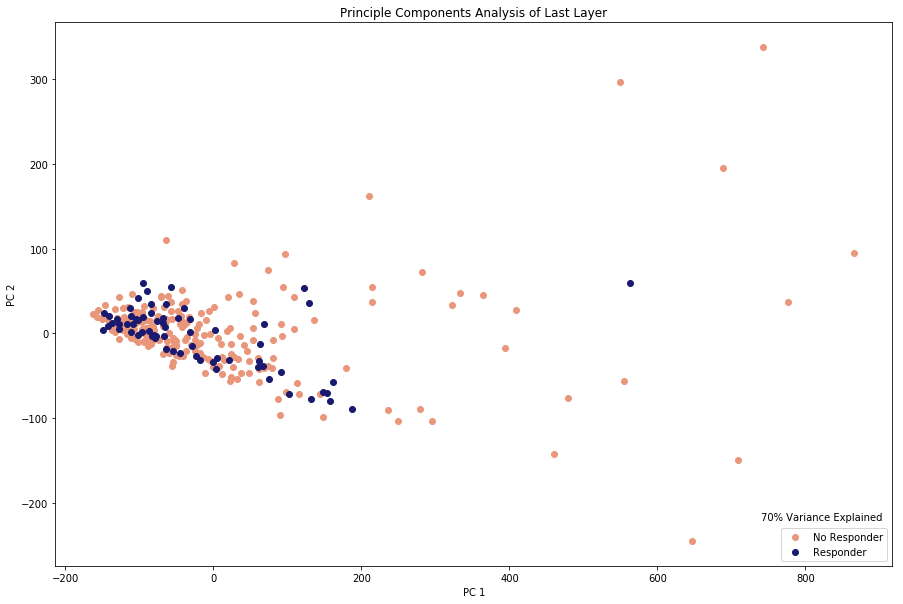

In [53]:
from matplotlib import pyplot as plt
import seaborn as sns
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

plt_x = data
plt_y = event

last_layer_weights = best_model.predict(plt_x)

# tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=5000)
# dr_res = tsne.fit_transform(last_layer_weights)

pca = PCA(n_components=2)
dr_res = pca.fit_transform(last_layer_weights)

pca_colors = ['darksalmon','midnightblue']

plt.figure(figsize=(15, 10))
for i, c, l in zip([0,1], pca_colors, ['No Responder', 'Responder']):
    plt.scatter(dr_res[plt_y == i, 0], dr_res[plt_y == i, 1], c=c, label=l)
plt.title('Principle Components Analysis of Last Layer')
plt.legend(loc="lower right")
plt.text(740, -220, "70% Variance Explained")
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [ ]:
predictions_type[1:10,:]

In [ ]:
plt.figure(figsize=(10, 10))
for i, c in zip([0,1], colors):
    plt.scatter(predictions_type[event == i, 0], predictions_type[event == i, 1], c=c, label=i)
plt.legend()
plt.show()

In [ ]:
tsne_results2 = tsne_results

In [ ]:
fig = plt.figure(figsize=(20, 16))
# colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i, c in zip(cancer_categories, colors):
    plt.scatter(tsne_results2[cancertypes == i, 0], tsne_results2[cancertypes == i, 1], c=c, label=i)
plt.legend()
plt.show()
fig.savefig("tsne_cancertypes")

In [ ]:
tsne_results_pd = pd.DataFrame(tsne_results2)
tsne_results_pd.to_csv("tsne_output.csv")